In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob 
import matplotlib.pyplot as plt
import matplotlib as mpl

sns.set_context("talk")
data_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/"

# load families summary
summary_homfam_exthomfam = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_exthomfam.csv")
summary_homfam = summary_homfam_exthomfam[summary_homfam_exthomfam.dataset == "homfam"]
families = summary_homfam.drop(["subset", "file", "min_length", "max_length", "perc_ref_total", "dataset"], axis = 1)

# 1. PREP SCORES
def get_scores(score_files): 
    def parse_score(score_file): 
        return(pd.read_csv(score_file,sep = ";", header = None).drop(4, axis = 1))

    scores = pd.concat(list(map(parse_score, score_files)))
    scores = scores.iloc[:,0:4]
    scores.columns = ['name', 'sp', 'tc', 'column']
    #scores.name = scores.name.str.split(".", expand = True)[:-1]
    #scores[["family", "method", "bucket_size", "align_method", "tree_method"]] = scores.name.str.split(".", expand = True)
    #scores = scores.drop("method", axis = 1)
    return(scores)


def plot_scatter_perc(df1,df2,xlabel,ylabel,
                      palette = sns.dark_palette("#3399FF", reverse = True, as_cmap=True),
                      log = True, 
                      title = "regressive on homfam", hue_var = "sim", metric = "sp", size_fig = 1): 
    f, ax = plt.subplots(figsize=(8*size_fig,6.4*size_fig ))
    
    # Prep df 
    df = df1.merge(df2, on = ["family", hue_var])
    
    
    hue = df[hue_var]
    # colorbar 
    norm = mpl.colors.Normalize( vmin=0, vmax=100)
    sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
    sm.set_array([])
    
# Color bar 
    cbar =ax.figure.colorbar(sm, ticks=[0,50,100], format=mpl.ticker.ScalarFormatter())
    cbar.ax.set_yticklabels(["0", "50", "100"]) 
    cbar.ax.set_ylabel('avg % similarity', rotation=270, labelpad = 20, fontsize = "small")
    
    metric_x = metric+"_x"
    metric_y = metric+"_y"
    # Plot 
    ax = sns.scatterplot(data = df, x = metric_x,
                    y = metric_y,
                    hue = hue_var,
                    s = 100,
                    palette = palette)

    # % above the line
    perc_y_better_than_x = (len(list(filter(lambda ele: ele == True, list(df[metric_x] <= df[metric_y])))) / len(list(df[metric_x]  >= df[metric_y] ))) * 100
    
    # Diagonal line
    ax.axline((1, 1), slope=1, ls="--", c=".2", lw = 0.8)
    
    ax.set(xlim = (0,100), ylim = (0,100))
    ax.get_legend().remove()
    
    # Axis labels
    ax.set(xlabel=xlabel,
           ylabel=ylabel,
           title = title + "\n metric: "+metric+"\n (n = "+str(len(df[metric_x] ))+") \n\n % y >= x  "+str(round(perc_y_better_than_x,1))+" \n")

In [ ]:


for line in Lines: 
    

In [36]:
library = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/libraries/sequence/rhv-ref/rhv-ref_sequence.library"


file1 = open(library, 'r')
Lines = file1.readlines()


count = 0
header_finished = False

seq_indexes = pd.DataFrame()
residues = pd.DataFrame()

# Strips the newline character
for line in Lines:
    if line.startswith("!"):
        count += 1
        continue
    if count == 0:
        count += 1
        continue
    elif count == 1: 
        nseq = int(line)
        count += 1
        continue
    elif count == nseq+2: 
        header_finished = True
    
    if not header_finished: 
        count += 1
        # ----- PARSE INDEXES SEQUENCES 
        seq_id = line.split()[0]
        seq = line.split()[2]
        idx_seq = count-2
        entry = pd.DataFrame({"index":[idx_seq], "seq_name":[seq_id]})
        seq_indexes = pd.concat([seq_indexes, entry])
    else:
        # ------- PARSE RESIDUES 
        if line.startswith("#"): 
            seq1 = line.replace("#","").split(" ")[0]
            seq2 = line.replace("#","").split(" ")[1]
        else:
            res1 = line.split()[0]
            res2 = line.split()[1]
            value = line.split()[2]
            res_entry = pd.DataFrame({"seq1":[seq1], "seq2":[seq2], "res1":[res1], "res2":[res2], "value":[value]})
            residues = pd.concat([residues,res_entry])
residues_seq = residues      

In [65]:
residues_seq

,seq1,seq2,res1,res2,value,id,library
0,1,2\n,1,1,56,1-2\n-1-1,sequence
0,1,2\n,1,13,22,1-2\n-1-13,sequence
0,1,2\n,1,17,16,1-2\n-1-17,sequence
0,1,2\n,1,19,61,1-2\n-1-19,sequence
0,1,2\n,1,20,27,1-2\n-1-20,sequence
...,...,...,...,...,...,...,...
0,5,6\n,850,800,999,5-6\n-850-800,sequence
0,5,6\n,851,801,999,5-6\n-851-801,sequence
0,5,6\n,852,802,999,5-6\n-852-802,sequence
0,5,6\n,853,803,999,5-6\n-853-803,sequence


In [42]:
residues_seq["id"] = residues_seq.seq1+"-"+residues_seq.seq2+"-"+residues_seq.res1+"-"+residues_seq.res2

In [46]:
residues_seq["library"] = "sequence"

In [45]:
library = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/libraries/foldseek/rhv-ref/rhv-ref.library"


file1 = open(library, 'r')
Lines = file1.readlines()


count = 0
header_finished = False

seq_indexes = pd.DataFrame()
residues = pd.DataFrame()

# Strips the newline character
for line in Lines:
    if line.startswith("!"):
        count += 1
        continue
    if count == 0:
        count += 1
        continue
    elif count == 1: 
        nseq = int(line)
        count += 1
        continue
    elif count == nseq+2: 
        header_finished = True
    
    if not header_finished: 
        count += 1
        # ----- PARSE INDEXES SEQUENCES 
        seq_id = line.split()[0]
        seq = line.split()[2]
        idx_seq = count-2
        entry = pd.DataFrame({"index":[idx_seq], "seq_name":[seq_id]})
        seq_indexes = pd.concat([seq_indexes, entry])
    else:
        # ------- PARSE RESIDUES 
        if line.startswith("#"): 
            seq1 = line.replace("#","").split(" ")[0]
            seq2 = line.replace("#","").split(" ")[1]
        else:
            res1 = line.split()[0]
            res2 = line.split()[1]
            value = line.split()[2]
            res_entry = pd.DataFrame({"seq1":[seq1], "seq2":[seq2], "res1":[res1], "res2":[res2], "value":[value]})
            residues = pd.concat([residues,res_entry])

In [64]:
residues_foldseek

,seq1,seq2,res1,res2,value,id,library
0,1,2\n,1,1,60,1-2\n-1-1,foldseek
0,1,2\n,1,19,62,1-2\n-1-19,foldseek
0,1,2\n,1,45,11,1-2\n-1-45,foldseek
0,1,2\n,2,20,70,1-2\n-2-20,foldseek
0,1,2\n,2,46,15,1-2\n-2-46,foldseek
...,...,...,...,...,...,...,...
0,5,6\n,852,802,959,5-6\n-852-802,foldseek
0,5,6\n,853,802,25,5-6\n-853-802,foldseek
0,5,6\n,853,803,959,5-6\n-853-803,foldseek
0,5,6\n,854,803,25,5-6\n-854-803,foldseek


In [47]:
residues_foldseek = residues
residues_foldseek["id"] = residues_foldseek.seq1+"-"+residues_foldseek.seq2+"-"+residues_foldseek.res1+"-"+residues_foldseek.res2
residues_foldseek["library"] = "foldseek"

In [131]:
df = pd.merge(residues_seq,residues_foldseek, on = "id", suffixes = ("_seq", "_foldseek"))
df["value_seq"] = (df.value_seq).astype(int)
df["value_foldseek"] = (df.value_foldseek).astype(int)

#df["value_seq"] = (df.value_seq/100).astype(int)
#df["value_foldseek"] = (df.value_foldseek/100).astype(int)

In [132]:
df

,seq1_seq,seq2_seq,res1_seq,res2_seq,value_seq,id,library_seq,seq1_foldseek,seq2_foldseek,res1_foldseek,res2_foldseek,value_foldseek,library_foldseek
0,1,2\n,1,1,56,1-2\n-1-1,sequence,1,2\n,1,1,60,foldseek
1,1,2\n,1,19,61,1-2\n-1-19,sequence,1,2\n,1,19,62,foldseek
2,1,2\n,2,20,61,1-2\n-2-20,sequence,1,2\n,2,20,70,foldseek
3,1,2\n,3,21,63,1-2\n-3-21,sequence,1,2\n,3,21,72,foldseek
4,1,2\n,4,22,66,1-2\n-4-22,sequence,1,2\n,4,22,72,foldseek
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13826,5,6\n,850,800,999,5-6\n-850-800,sequence,5,6\n,850,800,954,foldseek
13827,5,6\n,851,801,999,5-6\n-851-801,sequence,5,6\n,851,801,959,foldseek
13828,5,6\n,852,802,999,5-6\n-852-802,sequence,5,6\n,852,802,959,foldseek
13829,5,6\n,853,803,999,5-6\n-853-803,sequence,5,6\n,853,803,959,foldseek


<AxesSubplot:xlabel='value_seq', ylabel='value_foldseek'>

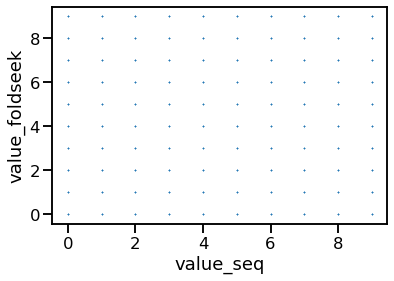

In [85]:
sns.scatterplot(data = df, x = "value_seq", y = "value_foldseek", s = 2)

df

In [133]:
df["seq1"] = df["seq1_seq"].apply(lambda x: seq_indexes[seq_indexes["index"] == int(x)].seq_name.item())

In [134]:
df["seq2"] = df["seq2_seq"].apply(lambda x: seq_indexes[seq_indexes["index"] == int(x)].seq_name.item())

In [127]:
df.head()

,seq1_seq,seq2_seq,res1_seq,res2_seq,value_seq,id,library_seq,seq1_foldseek,seq2_foldseek,res1_foldseek,res2_foldseek,value_foldseek,library_foldseek,seq1,seq2
0,1,2\n,1,1,0,1-2\n-1-1,sequence,1,2\n,1,1,0,foldseek,1bbt,1r1a
1,1,2\n,1,19,0,1-2\n-1-19,sequence,1,2\n,1,19,0,foldseek,1bbt,1r1a
2,1,2\n,2,20,0,1-2\n-2-20,sequence,1,2\n,2,20,0,foldseek,1bbt,1r1a
3,1,2\n,3,21,0,1-2\n-3-21,sequence,1,2\n,3,21,0,foldseek,1bbt,1r1a
4,1,2\n,4,22,0,1-2\n-4-22,sequence,1,2\n,4,22,0,foldseek,1bbt,1r1a


In [147]:
outfile = "/home/luisasantus/Desktop/test_print/rhv/run.sh"
f = open(outfile, "w")

prefix = "t_coffee -other_pg seq_reformat -in=rhv.aln -action +color_residue "
suffix = " -output color_html > sample_seq1_single.html"
f.write(prefix)
df.apply( lambda x: f.write(x.seq1+" "+x.res1_seq+" "+x.res2_seq+" "+str(x.value_seq)+" "), axis = 1)
f.write(suffix)
f.close()

In [143]:
main

0        None
1        None
2        None
3        None
4        None
         ... 
13826    None
13827    None
13828    None
13829    None
13830    None
Length: 13831, dtype: object